In [594]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim import models
from gensim.models import CoherenceModel
from gensim import corpora
import random
from gensim.models import Word2Vec
from gensim.models import word2vec
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/mz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 0-Data preprocessing

In [595]:
# 1.load sample dataset
train_df_sample = pd.read_csv('train_df_sample.csv').iloc[:,1:]
test_df_sample = pd.read_csv('test_df_sample.csv').iloc[:,1:]

In [596]:
train_df_sample.head(2)

,content,label
0,"JUDGE Judy Sheindlin, one of television’s bigg...",Media&Publications
1,Overview Calls to the Metropolitan Police abou...,Pharmaceutical


In [ ]:
# 2. content text clean : tokenize, keep strings only, remove stop words and Lemmatization

# get POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_content(row):
    # keep strings only
    cur_str = re.sub(r"[^A-Za-z ]", " ", row['content'])
    # tokenize
    cur_token = nltk.word_tokenize(cur_str)
    # remove stop words
    cur_token = [s.lower().strip() for s in cur_token if s.lower().strip() not in stopwords.words('english')]
    # get pos tag
    tagged_token = pos_tag(cur_token)     

    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_token:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        # lemmatization
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
    
    return lemmas_sent

In [ ]:
len(train_df_sample.iloc[:1].apply(lambda row : clean_content(row), axis = 1).iloc[0])

225

In [ ]:
train_df_sample['content_clean'] = train_df_sample.apply(lambda row : clean_content(row), axis = 1)
test_df_sample['content_clean'] = test_df_sample.apply(lambda row : clean_content(row), axis = 1)

In [64]:
#train_df_sample.to_csv('train_df_sample_clean.csv')
#test_df_sample.to_csv('test_df_sample_clean.csv')

In [592]:
#train_df_sample.to_pickle('train_df_sample_clean.pkl')
#test_df_sample.to_pickle('test_df_sample_clean.pkl')

In [593]:
train_df_sample.head(2)

,content,label
0,"JUDGE Judy Sheindlin, one of television’s bigg...",Media&Publications
1,Overview Calls to the Metropolitan Police abou...,Pharmaceutical


## 1- Topic model : LDA

In [65]:
# traning corpus
train_content_clean  = train_df_sample['content_clean'].tolist()

In [70]:
# test corpus
test_content_clean  = test_df_sample['content_clean'].tolist()

### 1.1 try to find a reasonable topic number

In [291]:
# sample still too large, so just choose 500 from them to determine the topic number
num_top_sample = random.sample(train_content_clean, 500)
dictionary = corpora.Dictionary(num_top_sample)
dictionary.filter_extremes(no_below=20, no_above=0.5)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in num_top_sample]
Lda = models.ldamodel.LdaModel
np.random.seed(1)

In [292]:
num_tps = list(range(5,55,5))

In [293]:
#ldamodel = Lda(doc_term_matrix, num_topics=25, id2word = dictionary, passes=10)

In [294]:
#ldamodel.log_perplexity(doc_term_matrix)

In [295]:
#goodcm = CoherenceModel(model=ldamodel, corpus= doc_term_matrix, dictionary=dictionary, coherence='u_mass')

In [296]:
#goodcm.get_coherence()

In [297]:
def plot_coherence(ls):
    scores = []
    for nt in num_tps:
        ldamodel = Lda(doc_term_matrix, num_topics=nt, id2word = dictionary, passes=10)
        coherence = CoherenceModel(model=ldamodel, corpus= doc_term_matrix, dictionary=dictionary, coherence='u_mass')
        perplexity = ldamodel.log_perplexity(doc_term_matrix)
        scores.append([nt,coherence.get_coherence(), perplexity])
    sc_df = pd.DataFrame(np.array(scores), columns = ['topic_num', 'coherence_score','perplexity'])
    print(sc_df)
    sc_df[['topic_num', 'coherence_score']].plot.line(x='topic_num', y='coherence_score')
    sc_df[['topic_num', 'perplexity']].plot.line(x='topic_num', y='perplexity')

   topic_num  coherence_score  perplexity
0        5.0        -1.164998   -6.647812
1       10.0        -1.378223   -6.671925
2       15.0        -1.352311   -6.728995
3       20.0        -1.518751   -6.802583
4       25.0        -1.454035   -6.818655
5       30.0        -1.536927   -6.844054
6       35.0        -1.544094   -6.910002
7       40.0        -1.571747   -6.919363
8       45.0        -1.462041   -6.976564
9       50.0        -1.566889   -7.014907


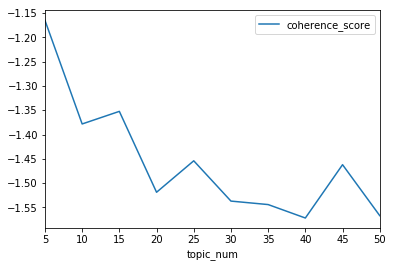

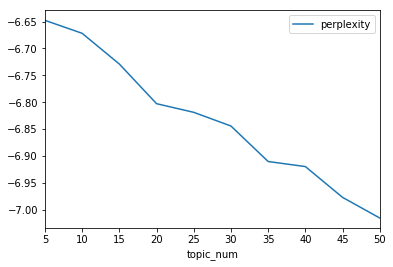

In [298]:
plot_coherence(num_tps)

### 1.2 use the num of topic was determined in 1.1 to train model

In [499]:
# build dictionary
dictionary = corpora.Dictionary(train_content_clean)
dictionary.filter_extremes(no_below=20, no_above=0.5)
doc_term_matrix_train = [dictionary.doc2bow(doc) for doc in train_content_clean]
Lda = models.ldamodel.LdaModel
np.random.seed(1)
ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=10)

In [500]:
coherence_train = CoherenceModel(model=ldamodel, corpus= doc_term_matrix_train, dictionary=dictionary, coherence='u_mass')
perplexity_train = ldamodel.log_perplexity(doc_term_matrix_train)

In [501]:
print('train set coherence score: %2f  train set perplexity score : %2f'% (coherence_train.get_coherence(), perplexity_train))

train set coherence score: -3.371643  train set perplexity score : -17.343138


In [502]:
doc_term_matrix_test = [dictionary.doc2bow(doc) for doc in test_content_clean]
coherence_test = CoherenceModel(model=ldamodel, corpus= doc_term_matrix_test, dictionary=dictionary, coherence='u_mass')
perplexity_test = ldamodel.log_perplexity(doc_term_matrix_test)

In [503]:
print('test set coherence score: %2f  test set perplexity score : %2f'% (coherence_test.get_coherence(), perplexity_test)) 

test set coherence score: -4.326310  test set perplexity score : -17.386724


In [505]:
print(ldamodel.print_topics(num_topics=15, num_words=15))

[(0, '0.021*"base" + 0.014*"cancer" + 0.013*"summary" + 0.012*"good" + 0.011*"rise" + 0.007*"canadian" + 0.007*"health" + 0.007*"effect" + 0.006*"number" + 0.006*"insurance" + 0.006*"organization" + 0.005*"dual" + 0.005*"yet" + 0.005*"equates" + 0.005*"day"'), (1, '0.031*"child" + 0.025*"publication" + 0.022*"richard" + 0.020*"fair" + 0.013*"could" + 0.006*"growth" + 0.006*"conclude" + 0.006*"apparent" + 0.005*"mini" + 0.005*"answer" + 0.005*"gadget" + 0.005*"archive" + 0.004*"factor" + 0.004*"hong" + 0.004*"beginning"'), (2, '0.011*"campaigner" + 0.011*"health" + 0.010*"britain" + 0.008*"cent" + 0.007*"freeze" + 0.007*"fifteen" + 0.007*"leave" + 0.007*"number" + 0.007*"proper" + 0.007*"voter" + 0.006*"good" + 0.006*"single" + 0.006*"facing" + 0.006*"frustrate" + 0.005*"name"'), (3, '0.001*"develop" + 0.001*"useful" + 0.001*"pharma" + 0.001*"base" + 0.001*"authenticity" + 0.001*"inflation" + 0.001*"increase" + 0.001*"noon" + 0.000*"wake" + 0.000*"number" + 0.000*"decade" + 0.000*"healt

### 1.3 prediction on test

In [581]:
# just given one example as we can use this to predict all test set
ldamodel.get_document_topics(doc_term_matrix_test[0])

[(0, 0.37932158), (2, 0.20102783), (4, 0.08902235), (8, 0.3215738)]

## 2 - Word2Vec + K-means 

In [467]:
train_df_sample.shape

(23280, 5)

In [468]:
train_data = train_df_sample['content_clean'].tolist()
test_data = test_df_sample['content_clean'].tolist()

In [469]:
# traing word2vec model
train_w2v = Word2Vec(train_data, min_count=5, size=500, window=25, workers=4)

In [470]:
# get document vector representation by avergae on each words belongs to it
def get_doc_avg_vec(row):
    vec = np.zeros(500)
    count = 1
    for word in row['content_clean']:
        try:
            vec += train_w2v[word]
            count+=1
            #print(count)
        except:
            pass
    return vec/count

In [471]:
train_df_sample['content_clean_w2v'] = train_df_sample.apply(lambda row : get_doc_avg_vec(row), axis = 1)

/Users/mz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [472]:
test_df_sample['content_clean_w2v'] = test_df_sample.apply(lambda row : get_doc_avg_vec(row), axis = 1)

/Users/mz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [473]:
train_df_sample.head(2)

,raw_content,content,label,content_clean,content_clean_w2v
0,"JUDGE Judy Sheindlin, one of television’s big...","JUDGE Judy Sheindlin, one of television’s bigg...",Media&Publications,"[judge, judy, sheindlin, one, television, big,...","[0.18067191459910234, 0.14731993270724747, 0.3..."
1,Overview Calls to the Metropolitan Police abo...,Overview Calls to the Metropolitan Police abou...,Pharmaceutical,"[overview, call, metropolitan, police, mental,...","[0.27423277886334657, -0.09801484441295576, 0...."


In [475]:
X = np.array(train_df_sample['content_clean_w2v'].tolist())

   num_clusters            SSE
0           5.0  537793.400110
1          10.0  472933.624912
2          15.0  433312.491005
3          20.0  409447.173952
4          25.0  391208.753750
5          30.0  377425.810179
6          35.0  366567.865012
7          40.0  357522.621233
8          45.0  349554.870251
9          50.0  342355.848923


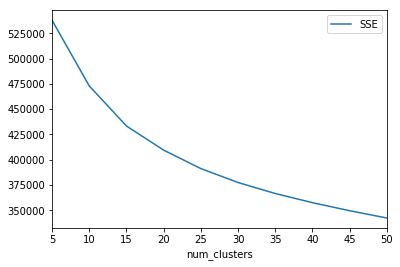

In [478]:
res = []
n_cluster = list(range(5,55,5))
for n in n_cluster:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    #res.append()#euclidean
    res.append([n, kmeans.inertia_])
'''
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
'''
res_df = pd.DataFrame(np.array(res), columns = ['num_clusters', 'SSE'])
print(res_df)
res_df[['num_clusters', 'SSE']].plot.line(x='num_clusters', y='SSE')

In [506]:
# choose 15 as number of clusters
kmeans_model = KMeans(n_clusters=15).fit(X)

In [566]:
# top 15 centre words of each clusters
center_words_15 = []

In [567]:
# map keywords by its index in word2vec model
w2v_dict = {}
for k,v in enumerate(train_w2v.wv.index2word):
    w2v_dict[k] = v

In [568]:
# look up top 15 weighted keywords in each cluster
for cls in kmeans_model.cluster_centers_:
    idx = list(cls.argsort()[::-1][:15])
    idx2wd = [w2v_dict[i] for i in idx]
    center_words_15.append(idx2wd)

In [570]:
# print centre words for each clusters
np.array(center_words_15)

array([['average', 'fire', 'company', 'way', 'capital', 'energy',
        'final', 'state', 'economic', 'raise', 'region', 'country',
        'control', 'sydney', 'national'],
       ['target', 'service', 'total', 'need', 'au', 'come', 'focus',
        'mr', 'law', 'different', 'manager', 'million', 'melbourne',
        'police', 'site'],
       ['life', 'average', 'capital', 'world', 'final', 'together',
        'change', 'national', 'investor', 'form', 'state', 'far',
        'country', 'list', 'melbourne'],
       ['back', 'demand', 'local', 'station', 'way', 'raise', 'company',
        'state', 'away', 'know', 'base', 'student', 'appear', 'whether',
        'key'],
       ['key', 'low', 'tell', 'leader', 'review', 'call', 'plan', 'area',
        'driver', 'online', 'position', 'queensland', 'woman',
        'saturday', 'station'],
       ['way', 'fire', 'target', 'come', 'focus', 'late', 'join',
        'capital', 'may', 'offer', 'company', 'base', 'melbourne',
        'power', 'op

In [583]:
# testset
X_test = np.array(test_df_sample['content_clean_w2v'].tolist())

(5821,)

In [585]:
# predict on testset
kmeans_model.predict(X_test)

array([9, 5, 1, ..., 5, 8, 0], dtype=int32)